In [1]:
# Train embedding models (word2vec)
from pre_process import PreProcessor
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os, tqdm

## Load corpus and tokenizing

In [2]:
topics = ['Trai_dat', 'Hoa_hoc', 'Dong_vat', 'Khoa_hoc_moi_truong']
data_dir = './data'

def read_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

pre_processor = PreProcessor(stopword = None, tokenizer = 'pyvi')
# pre_processor = PreProcessor(stopword = None, tokenizer = None)
    
data_mapper = dict()
for topic in topics:
    files = [os.path.join(data_dir, topic, f) for f in os.listdir(os.path.join(data_dir, topic))]
    questions = [read_file(f) for f in files]
    data_mapper[topic] = [s.lower() for q in questions for s in pre_processor.pre_process(q)]

In [3]:
data_mapper

{'Trai_dat': ['hồng_triều là thế_nào',
  'vì_sao trong động đá_vôi nhũ_đá thì chảy xuống dưới còn măng_đá lại mọc hướng lên trên',
  'vì_sao lại có hồ nước_ngọt hồ nước_mặn',
  'vì_sao có_thể lợi_dụng thuỷ_triều để phát_điện',
  'có những phương_pháp nào để ngọt hoá nước biển',
  'mùa hè vì_sao thường có mưa giông',
  'năm 1998 vùng trường_giang nộn_giang và sông tùng hoa trung_quốc gặp trận lụt to hiếm thấy trong đó những lỗ rò ở các thân đê đặc_biệt nghiêm_trọng có lúc dẫn đến vỡ đê gây nên tổn_thất người và của rất lớn',
  'tám giờ tối_ngày 1 tháng 8 ở đê phái châu_loan huyện gia_ngư tỉnh hồ bắc phía bờ nam sông trường_giang cách chân đê 40 m xuất_hiện một lỗ rò mạnh',
  'mặc_dù lực_lượng canh đê đã ra_sức cứu_chữa nhưng 30 phút sau đê bị vỡ',
  'lần vỡ đê đó làm cho 83 km2 ngập nước gây thiệt_hại hơn năm vạn người mất nhà ở',
  '1 giờ chiều ngày 7 tháng 8 bờ đê sông trường_giang ở thành_phố cửu_giang bị vỡ gây nên một trận lụt lớn',
  'lỗ rò là chỉ trong điều_kiện mực nước phía trê

In [4]:
from collections import Counter
token_counter = Counter(list([token for sentences in data_mapper.values()
                                    for sentence in sentences
                                    for token in sentence.split()]))

In [5]:
token_counter.most_common(10)

[('có', 7267),
 ('là', 6523),
 ('của', 6407),
 ('các', 5445),
 ('trong', 4975),
 ('và', 4745),
 ('không', 3782),
 ('được', 3684),
 ('một', 3676),
 ('ở', 3007)]

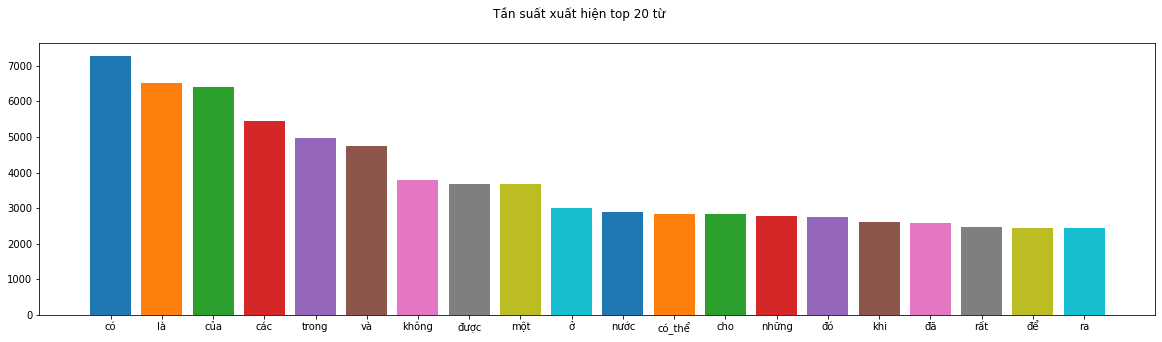

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 5))
for pair in token_counter.most_common(20):
    plt.bar(pair[0], pair[1])
plt.suptitle('Tần suất xuất hiện top 20 từ')
plt.show()

## Load pretrained Word2vec model

In [7]:
from gensim.models import KeyedVectors

In [8]:
embedding_model = KeyedVectors.load_word2vec_format('./baomoi.model.bin', binary=True)

In [9]:
embedding_model.most_similar('vua', topn=10)

[('hoàng_đế', 0.7260753512382507),
 ('hoàng_hậu', 0.563833475112915),
 ('hoàng_Đế', 0.5562083721160889),
 ('lê_uy_mục', 0.5473478436470032),
 ('mạc_Đăng_dung', 0.5401350855827332),
 ('thái_tông', 0.5305336713790894),
 ('thần', 0.5304694175720215),
 ('tướng_quân', 0.5301997661590576),
 ('tể_tướng', 0.5292617082595825),
 ('lý_cao_tông', 0.5242230296134949)]

In [10]:
def word2idx(word):
    try:
        return embedding_model.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def idx2word(token):
    return embedding_model.index2word[token]

In [11]:
word2idx('vua'), idx2word(1996)

(1804, 'chín')

In [12]:
vocab_size = len(token_counter)
embedding_dim = embedding_model.syn0.shape[1]
max_sentence_len = 20
total_sentences_count = len([sentence for sentences in data_mapper.values() for sentence in sentences])

<ipython-input-12-1ec19f984e72>:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  embedding_dim = embedding_model.syn0.shape[1]


In [13]:
from d2l import mxnet as d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn, rnn
npx.set_np()

In [14]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, num_class, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(num_class)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [15]:
import random
def load_data(batch_size, num_steps=500, train_proportion = 0.8):
    train_data, test_data = [[], []], [[], []]
    for idx, topic in enumerate(topics):
        # shuffle data
        random.shuffle(data_mapper[topic])
        # append train data
        train_size = int(len(data_mapper[topic]) * train_proportion)
        _train = data_mapper[topic][:train_size]
        train_data[0].extend(_train)
        train_data[1].extend([idx] * len(_train))
        # append test data
        _test = data_mapper[topic][train_size:]
        test_data[0].extend(_test)
        test_data[1].extend([idx] * len(_test))
    
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab.unk) for line in train_tokens])
    test_features = np.array([d2l.truncate_pad(
        vocab[line], num_steps, vocab.unk) for line in test_tokens])
    train_iter = d2l.load_array((train_features, train_data[1]), batch_size)
    test_iter = d2l.load_array((test_features, test_data[1]), batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [16]:
train_iter, test_iter, vocab = load_data(64)

In [17]:
embedding_model.vocab

{'<punct>': <gensim.models.keyedvectors.Vocab at 0x159c71fd0>,
 '<number>': <gensim.models.keyedvectors.Vocab at 0x159c71c40>,
 'của': <gensim.models.keyedvectors.Vocab at 0x159c71a30>,
 'và': <gensim.models.keyedvectors.Vocab at 0x15b1267f0>,
 'là': <gensim.models.keyedvectors.Vocab at 0x15b126850>,
 'các': <gensim.models.keyedvectors.Vocab at 0x15b1268b0>,
 'trong': <gensim.models.keyedvectors.Vocab at 0x15b126940>,
 'có': <gensim.models.keyedvectors.Vocab at 0x15b1269a0>,
 'được': <gensim.models.keyedvectors.Vocab at 0x15b126a00>,
 'cho': <gensim.models.keyedvectors.Vocab at 0x15b126a60>,
 'đã': <gensim.models.keyedvectors.Vocab at 0x15b126ac0>,
 'với': <gensim.models.keyedvectors.Vocab at 0x15b126b20>,
 'không': <gensim.models.keyedvectors.Vocab at 0x15b126b80>,
 'một': <gensim.models.keyedvectors.Vocab at 0x15b126be0>,
 'những': <gensim.models.keyedvectors.Vocab at 0x15b126c70>,
 'người': <gensim.models.keyedvectors.Vocab at 0x15b126cd0>,
 'khi': <gensim.models.keyedvectors.Vocab 

In [18]:
embeds = embedding_model[[w for w in vocab.idx_to_token if w in embedding_model.vocab]]
embeds.shape

(3942, 400)

In [19]:
len(vocab.idx_to_token)

4198

In [25]:
embed_size, num_hiddens, num_layers, devices = 400, 100, 2, d2l.try_all_gpus()
net = BiRNN(embeds.shape[0], embed_size, num_hiddens, num_layers, len(topics))
net.initialize(init.Xavier(), ctx=devices)

In [26]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

In [ ]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)